<a href="https://colab.research.google.com/github/JakeOh/202511_BD53/blob/main/lab_ml/ml05_regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

머신 러닝(Machine Learning) 종류 - 사람의 감독 하에 훈련하는 것인 지 여부
*   지도 학습(Supervised learning): 레이블(타겟)이 있는 데이터를 학습.
    *   분류(Classification): 클래스들을 분류.
    *   회귀(Regression): 수치 예측.
*   비지도 학습(Unsupervised learning): 레이블이 없는 데이터를 학습.
    *   군집화(Clustering)
    *   시각화(Visualization)
*   준지도 학습(semi-superivsed learning): 비지도 학습 + 전문가 시스템.

# 문제

fish 데이터셋에서 물고기의 무게(Weight)를 예측.
*   농어(Perch)의 무게(Weight)를 길이(Length) 특성만으로 예측.
    *   Weight ~ Length
    *   무게(Weight): 관심 변수, 종속 변수, 레이블, 타겟.
    *   길이(Length): 독립 변수, 특성(feature).
    *   KNN, Linear Regression(선형 회귀)
*   농어의 무게를 다른 4개의 특성들을 사용해서 예측.
    *   Weight ~ Length + Diagonal + Height + Width
    *   Linear Regression

# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler  # 표준화(특성 스케일링)
from sklearn.preprocessing import PolynomialFeatures  # 다차항을 추가할 수 있는 변환기
from sklearn.neighbors import KNeighborsRegressor  # KNN 알고리즘을 사용한 회귀.
from sklearn.linear_model import LinearRegression  # 선형 회귀
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score  # 회귀 평가 지표
from sklearn.pipeline import Pipeline  # 변환기와 추정기를 연결하는 클래스.

# Fish 데이터셋 준비

In [2]:
file_path = 'https://bit.ly/fish_csv_data'

In [3]:
fish = pd.read_csv(file_path)

In [4]:
fish

,Species,Weight,Length,Diagonal,Height,Width
0,Bream,242.0,25.4,30.0,11.5200,4.0200
1,Bream,290.0,26.3,31.2,12.4800,4.3056
2,Bream,340.0,26.5,31.1,12.3778,4.6961
3,Bream,363.0,29.0,33.5,12.7300,4.4555
4,Bream,430.0,29.0,34.0,12.4440,5.1340
...,...,...,...,...,...,...
154,Smelt,12.2,12.2,13.4,2.0904,1.3936
155,Smelt,13.4,12.4,13.5,2.4300,1.2690
156,Smelt,12.2,13.0,13.8,2.2770,1.2558
157,Smelt,19.7,14.3,15.2,2.8728,2.0672


농어(Perch)의 무게(Weight)를 길이(Length)만으로 예측할 수 있을까?

*   특성(features): Length --> (n_samples, n_features) 모양의 **2차원 배열**
*   타겟(target): Weight  --> (n_samples,) 모양의 **1차원 배열**


In [5]:
perch = fish[fish.Species == 'Perch']

In [6]:
perch.head()

,Species,Weight,Length,Diagonal,Height,Width
72,Perch,5.9,8.4,8.8,2.1120,1.4080
73,Perch,32.0,13.7,14.7,3.5280,1.9992
74,Perch,40.0,15.0,16.0,3.8240,2.4320
75,Perch,51.5,16.2,17.2,4.5924,2.6316
76,Perch,70.0,17.4,18.5,4.5880,2.9415


In [7]:
perch.info()

<class 'pandas.core.frame.DataFrame'>
Index: 56 entries, 72 to 127
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Species   56 non-null     object 
 1   Weight    56 non-null     float64
 2   Length    56 non-null     float64
 3   Diagonal  56 non-null     float64
 4   Height    56 non-null     float64
 5   Width     56 non-null     float64
dtypes: float64(5), object(1)
memory usage: 3.1+ KB


In [10]:
# 특성 배열(feauture array)
x = perch[['Length']].values
x.shape  #> (56, 1) = (n_samples, n_feautres)

(56, 1)

In [12]:
# 타겟 배열(target array)
y = perch['Weight'].values
y.shape  #> (56,) = (n_samples,)

(56,)

# 훈련 셋, 테스트 셋 분리

In [13]:
# 임의 추출(random sampling)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25,
                                                    random_state=42)

In [16]:
x_train.shape

(42, 1)

In [17]:
x_test.shape

(14, 1)

In [18]:
y_train.shape

(42,)

In [19]:
y_test.shape

(14,)

훈련 셋, 테스트 셋 시각화: weight(y) ~ length(x) 산점도. 색깔(훈련/테스트)

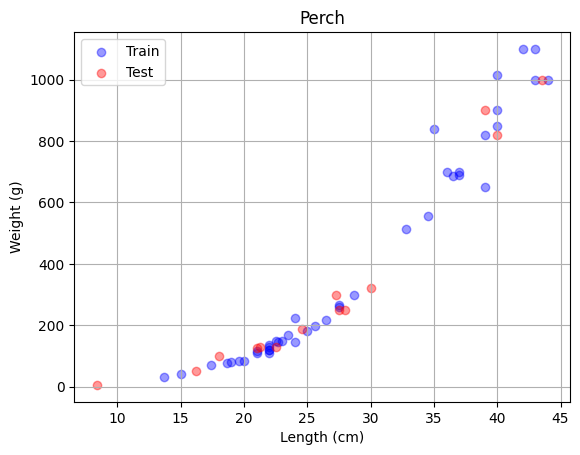

In [29]:
plt.scatter(x=x_train, y=y_train, label='Train', alpha=0.4, color='blue')
plt.scatter(x=x_test, y=y_test, label='Test', alpha=0.4, color='red')

plt.legend()
plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.title('Perch')
plt.grid()
plt.show()

# KNN 모델 훈련, 평가

KNN(K-Nearest Neighbors) Regressor: k개의 가장 가까운 이웃들의 레이블 평균 값으로 수치를 예측하는 머신 러닝 모델.

In [30]:
knn = KNeighborsRegressor()  # KNN 모델 생성

In [31]:
knn.fit(X=x_train, y=y_train)  # KNN 모델 훈련

KNeighborsRegressor()

In [32]:
train_pred = knn.predict(X=x_train)  # 훈련 셋의 예측값

In [33]:
train_pred

array([  88.6,  123. ,   79.6,   70.6,  723. ,  193. ,  847. ,  847. ,
       1010. ,  123. ,   95. ,  123. ,  174. ,  248. , 1010. ,  847. ,
        174. ,  113. ,  248. ,  847. ,  659. ,  224. ,  723. ,   60. ,
        140. ,   60. ,  719. ,  694.2,  248. ,  167. ,  847. ,  113. ,
        168. ,  123. , 1010. ,  136. ,   79.6,  719. ,  123. ,  193. ,
        990. ,  659. ])

In [34]:
y_train  # 훈련 셋 실젯값

array([  85.,  135.,   78.,   70.,  700.,  180.,  850.,  820., 1000.,
        120.,   85.,  130.,  225.,  260., 1100.,  900.,  145.,  115.,
        265., 1015.,  514.,  218.,  685.,   32.,  145.,   40.,  690.,
        840.,  300.,  170.,  650.,  110.,  150.,  110., 1000.,  150.,
         80.,  700.,  120.,  197., 1100.,  556.])

In [35]:
test_pred = knn.predict(X=x_test)  # 테스트 셋의 예측값
test_pred

array([  60. ,   79.6,  248. ,  122. ,  136. ,  847. ,  311.4,  183.4,
        847. ,  113. , 1010. ,   60. ,  248. ,  248. ])

In [36]:
y_test  # 테스트 셋 실젯값

array([   5.9,  100. ,  250. ,  130. ,  130. ,  820. ,  320. ,  188. ,
        900. ,  125. , 1000. ,   51.5,  250. ,  300. ])

# 회귀 모델의 평가 지표(metrics)

*   MSE(Mean Squared Errors): 오차들의 제곱의 평균.
*   RMSE(Root Mean Squared Errors): MSE의 제곱근.
*   MAE(Mean Absolute Errors): 오차들의 절댓값의 평균.
*   MSE, RMSE, MAE는 값이 작을 수록 좋은 점수, 값이 클 수록 나쁜 점수!
    *   일반적으로 점수(평가지표)는 값이 클 수록 좋은 점수, 값이 작을 수록 나쁜 점수.
    *   회귀 문제에서도 오차들이 작을 수록 점수가 커지는 평가지표를 개발 -> R2 score(결정 계수)
*   R2 score(결정계수): -무한대(infinite) ~ 1 사이의 값을 가질 수 있음.
    *   모든 수치를 오차없이 정확하게 예측한 경우 최댓값 1.
    *   오차들이 클 수록 결정계수는 작아짐.

* $ y_i $ : $i$번째 샘플의 실젯값(label)
* $ \hat{y_i} $ : $i$번째 샘플의 예측값
* $ \bar{y} $ : 타겟의 평균값
* $ n $ : 샘플 개수

* MAE(Mean Absolute Errors)
$$
MAE = \frac{1}{n} \sum_{i=1}^{n} \lvert y_i - \hat{y_i} \rvert
$$

* MSE(Mean Squared Errors)
$$
MSE = \frac{1}{n} \sum_{i=1}^{n} ( y_i - \hat{y_i} )^2
$$

* RMSE(Root Mean Squared Errors)
$$
RMSE = \sqrt{ \frac{1}{n} \sum_{i=1}^{n} ( y_i - \hat{y_i} )^2 }
$$

* $ R^2 $ score(Coefficient of determinant, 결정 계수)
$$
R^2 = 1 - \dfrac{\text{MSE}}{\text{Variance}}
    = 1 - \dfrac{ \sum_{i=1}^{n} (y_i - \hat{y_i})^2 }
                { \sum_{i=1}^{n} (y_i - \bar{y})^2 }
$$
    * 결정 계수는 최댓값이 1이 되도록 만든 평가 지표.
    * 모델이 타겟을 오차없이 정확하게 예측하면, 실제값 - 예측값 = 0 이므로, 결정 계수는 최댓값 1이 됨.
    * 모델이 타겟을 매우 비슷하게 예측하면, 오차가 매우 작으면 분자가 0에 가까운 값이 되므로, 결정 계수는 1보다는 작지만 1에 가까운 값이 됨.
    * 모델이 타겟의 평균으로만 예측하는 정도라면, (분자) = (분모) 이므로, 결정 계수는 0이 됨.
    * 모델이 타겟의 평균 정도도 예측하지 못하면(오차가 매우 크면), (분자) > (분모)일 수 있고, 그런 경우 결정 계수는 음수가 될 수 있음.

In [37]:
# 훈련 셋의 MSE
mean_squared_error(y_true=y_train, y_pred=train_pred)

3716.5161904761903

In [38]:
# 훈련 셋의 RMSE
np.sqrt(mean_squared_error(y_train, train_pred))

np.float64(60.96323638453089)

In [39]:
# 훈련 셋의 MAE
mean_absolute_error(y_true=y_train, y_pred=train_pred)

35.76190476190476

In [40]:
# 훈련 셋의 결정계수(R2 score)
r2_score(y_true=y_train, y_pred=train_pred)

0.9698823289099254

In [41]:
# 훈련된 KNN 모델에서 score 메서드를 호출 -> 결정계수 리턴.
knn.score(X=x_train, y=y_train)

0.9698823289099254

In [42]:
# KNN 모델에서 score 메서드를 호출해서 테스트 셋의 결정계수 계산
knn.score(X=x_test, y=y_test)

0.992809406101064

테스트 셋의 평가 점수가 훈련 셋에서의 평가 점수보다 더 좋은 --> 과소적합(under-fitting)

In [43]:
# 테스트 셋의 MAE
mean_absolute_error(y_true=y_test, y_pred=test_pred)

19.157142857142862

In [44]:
# 테스트 셋의 MSE
mean_squared_error(y_true=y_test, y_pred=test_pred)

721.7385714285714

# KNN Regressor 문제점

outlier가 있는 경우 오차가 커질 수가 있음.

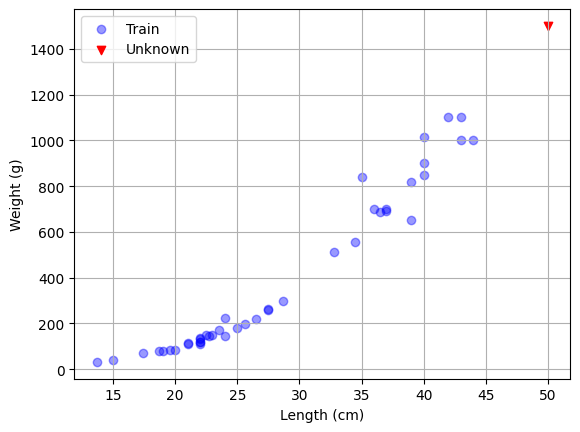

In [47]:
# 훈련 셋 시각화
plt.scatter(x=x_train, y=y_train, label='Train', color='blue', alpha=0.4)

# 가상의 물고기(50cm, 1500g)
plt.scatter(x=50, y=1500, label='Unknown', color='red', marker='v')

plt.legend()
plt.grid()
plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.show()

길이가 50cm인 물고기 무게 예측

In [50]:
# 길이가 50cm인 물고기와 가장 가까운 5개의 이웃들(훈련 셋 샘플들)
distances, indices = knn.kneighbors(X=[[50]])
print(distances)
print(indices)

[[ 6.  7.  7.  8. 10.]]
[[34 14  8 40  6]]


In [51]:
# 5개 가장 가까운 이웃들의 무게(레이블)
y_train[indices[0]]

array([1000., 1100., 1000., 1100.,  850.])

In [52]:
# 가장 가까운 이웃들의 무게 평균
np.mean(y_train[indices[0]])

np.float64(1010.0)

In [53]:
knn.predict(X=[[50]])

array([1010.])

머신 러닝의 종류 - 단순하게 알고 있는 데이터 포인트와 새 데이터 포인트를 비교하는 것인 지, 아니면 훈련 셋에서 패턴을 발견(수학적인 공식을 발견)해서 예측 모델을 만드는 지

*   사례 기반 머신 러닝(instance-based ML)
    *   수학적인 모델을 만들 지 않고, 훈련 셋의 특성들을 사용해서 예측.
    *   outlier들이 많은 경우에는 성능이 안좋아질 수 있음.
    *   KNN, Decision Tree, ...
*   모델 기반 머신 러닝(model-based ML)
    *   훈련 셋의 특성들에서 수학적인 모델을 만들고, 그 수학 모델로 예측.
    *   Linear Regression(선형 회귀), Logistic Regression(로지스틱 회귀), ...
    

# Linear Regression(선형 회귀)

In [54]:
lin_reg = LinearRegression()  # 선형 회귀 모델 생성

In [55]:
lin_reg.fit(X=x_train, y=y_train)  # 선형 회귀 모델 훈련
#> MSE가 최소가 되는 선형 회귀식의 계수(들)과 절편(들)을 찾는 과정.

LinearRegression()

In [56]:
lin_reg.coef_  # x의 계수(y = ax + b에서 a에 해당하는 값)

array([39.01714496])

In [57]:
lin_reg.intercept_  # 절편(y = ax + b에서 b에 해당하는 값)

np.float64(-709.0186449535477)

선형 회귀 모델에서 찾은 선형회귀식: $ y = 39x - 709 $

In [58]:
train_pred = lin_reg.predict(X=x_train)  # 선형회귀에서 훈련 셋의 예측값
train_pred

array([  55.71739633,  149.35854425,   20.60196587,  -30.12032259,
        695.59857374,  266.40997914,  851.66715359,  812.65000863,
        968.71858848,  149.35854425,   71.32425432,  149.35854425,
        227.39283417,  363.95284155,  968.71858848,  851.66715359,
        227.39283417,  110.34139928,  363.95284155,  851.66715359,
        570.74370985,  324.93569658,  715.10714622, -174.48375895,
        176.67054572, -123.7614705 ,  734.6157187 ,  656.58142877,
        410.7734155 ,  207.88426169,  812.65000863,  110.34139928,
        188.37568921,  149.35854425, 1007.73573345,  168.86711673,
         32.30710936,  734.6157187 ,  149.35854425,  289.82026612,
        929.70144352,  637.07285629])

In [59]:
y_train

array([  85.,  135.,   78.,   70.,  700.,  180.,  850.,  820., 1000.,
        120.,   85.,  130.,  225.,  260., 1100.,  900.,  145.,  115.,
        265., 1015.,  514.,  218.,  685.,   32.,  145.,   40.,  690.,
        840.,  300.,  170.,  650.,  110.,  150.,  110., 1000.,  150.,
         80.,  700.,  120.,  197., 1100.,  556.])

In [60]:
# 훈련 셋의 MSE
mean_squared_error(y_true=y_train, y_pred=train_pred)

7422.953552609781

In [61]:
# 훈련 셋의 결정계수
r2_score(y_true=y_train, y_pred=train_pred)

0.939846333997604

In [62]:
# 테스트 셋의 예측값
test_pred = lin_reg.predict(X=x_test)
test_pred

array([-381.27462726,   -6.71003561,  363.95284155,  122.04654277,
        168.86711673,  851.66715359,  461.49570396,  250.80312115,
        812.65000863,  110.34139928,  988.22716096,  -76.94089654,
        383.46141403,  356.14941255])

In [63]:
y_test

array([   5.9,  100. ,  250. ,  130. ,  130. ,  820. ,  320. ,  188. ,
        900. ,  125. , 1000. ,   51.5,  250. ,  300. ])

In [64]:
# 테스트 셋의 MSE
mean_squared_error(y_true=y_test, y_pred=test_pred)

17590.265977889187

In [65]:
# 테스트 셋의 결정계수
r2_score(y_true=y_test, y_pred=test_pred)

0.8247503123313558

훈련 셋의 점수(0.94)가 테스트 셋의 점수(0.82)보다 훨씬 좋음 --> 과대적합(over-fitting)

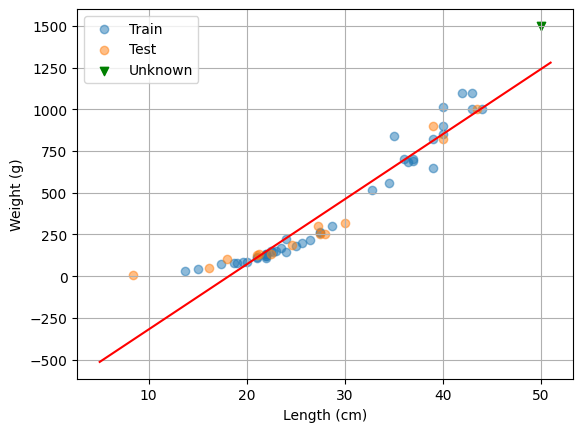

In [71]:
# 훈련 셋 산점도
plt.scatter(x=x_train, y=y_train, label='Train', alpha=0.5)

# 테스트 셋 산점도
plt.scatter(x=x_test, y=y_test, label='Test', alpha=0.5)

# y = 39x - 709 일차함수(직선) 시각화
x_val = np.arange(5, 51, 0.001)
y_val = 39 * x_val - 709
plt.plot(x_val, y_val, 'r-')

# 가상의 물고기(50cm, 1500g) 시각화
plt.scatter(x=50, y=1500, color='green', marker='v', label='Unknown')

plt.legend()
plt.xlabel('Length (cm)')
plt.ylabel('Weight (g)')
plt.grid()
plt.show()

# 다항 회귀

2개 이상의 변수(특성)을 사용하는 선형 회귀.

2차항 이상을 포함하는 선형 회귀.

In [73]:
x_train.shape  #> (42, 1) 모양

(42, 1)

In [74]:
# 2차항을 추가한 훈련 셋 2차원 배열
x_train_poly = np.c_[x_train ** 2, x_train]

In [76]:
x_train_poly[:6]

array([[ 384.16,   19.6 ],
       [ 484.  ,   22.  ],
       [ 349.69,   18.7 ],
       [ 302.76,   17.4 ],
       [1296.  ,   36.  ],
       [ 625.  ,   25.  ]])

In [77]:
x_train_poly.shape

(42, 2)

In [78]:
# 2차항을 추가한 테스트 셋 2차원 배열
x_test_poly = np.c_[x_test ** 2, x_test]

In [79]:
x_test_poly

array([[  70.56,    8.4 ],
       [ 324.  ,   18.  ],
       [ 756.25,   27.5 ],
       [ 453.69,   21.3 ],
       [ 506.25,   22.5 ],
       [1600.  ,   40.  ],
       [ 900.  ,   30.  ],
       [ 605.16,   24.6 ],
       [1521.  ,   39.  ],
       [ 441.  ,   21.  ],
       [1892.25,   43.5 ],
       [ 262.44,   16.2 ],
       [ 784.  ,   28.  ],
       [ 745.29,   27.3 ]])

In [80]:
x_test_poly.shape  #> (14, 2)

(14, 2)

In [81]:
lin_reg = LinearRegression()  # 선형회귀 모델 생성

In [82]:
# 2차항(길이의 제곱)을 포함하는 훈련 셋으로 모델을 훈련
# -> 계수(coefficients)와 절편(intercept)을 찾음.
lin_reg.fit(X=x_train_poly, y=y_train)

LinearRegression()

In [83]:
lin_reg.coef_

array([  1.01433211, -21.55792498])

$ y = ax^2 + bx + c $ 회귀식에서 계수 a와 b를 의미.

In [84]:
lin_reg.intercept_

np.float64(116.0502107827827)

$ y = ax^2 + bx + c $ 회귀식에서 절편 c를 의미

In [85]:
# 훈련 셋 예측값
train_pred = lin_reg.predict(X=x_train_poly)
train_pred

array([  83.18070434,  132.71260219,   67.61880901,   48.04150559,
        654.5393253 ,  211.05965467,  876.66458663,  818.09027497,
       1064.55950693,  132.71260219,   90.62455496,  132.71260219,
        182.91530629,  290.29593158, 1064.55950693,  876.66458663,
        182.91530629,  110.65424646,  290.29593158,  876.66458663,
        500.20932803,  257.07992265,  680.52990177,   11.08663218,
        149.3605064 ,   20.90606071,  707.0276443 ,  604.07967051,
        332.83297906,  169.60388118,  818.09027497,  110.65424646,
        156.79962213,  132.71260219, 1131.24847547,  144.50252913,
         72.62352767,  707.0276443 ,  132.71260219,  228.92002253,
        999.89920261,  579.6105922 ])

In [87]:
y_train

array([  85.,  135.,   78.,   70.,  700.,  180.,  850.,  820., 1000.,
        120.,   85.,  130.,  225.,  260., 1100.,  900.,  145.,  115.,
        265., 1015.,  514.,  218.,  685.,   32.,  145.,   40.,  690.,
        840.,  300.,  170.,  650.,  110.,  150.,  110., 1000.,  150.,
         80.,  700.,  120.,  197., 1100.,  556.])

In [88]:
# 훈련 셋 결정계수
r2_score(y_true=y_train, y_pred=train_pred)

0.9706807451768623

In [89]:
# 테스트 셋 예측값
test_pred = lin_reg.predict(X=x_test_poly)
test_pred

array([   6.5349146 ,   56.6511646 ,  290.29593158,  117.05874344,
        144.50252913,  876.66458663,  382.21135986,  199.55847561,
        818.09027497,  110.65424646, 1097.65040817,   33.01314491,
        307.66468513,  283.49043666])

In [90]:
y_test

array([   5.9,  100. ,  250. ,  130. ,  130. ,  820. ,  320. ,  188. ,
        900. ,  125. , 1000. ,   51.5,  250. ,  300. ])

In [91]:
# 테스트 셋 결정계수
r2_score(y_true=y_test, y_pred=test_pred)

0.9775935108325122